# Q5 Smoke Status Recognition

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Machine Learning
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Load Data

In [2]:
train_data = pd.read_excel('Data_Q5/Q5_train.xlsx')
test_data = pd.read_csv('Data_Q5/Q5_test.csv')

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           149701 non-null  float64
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159248 non-null  float64
 5   eyesight(left)       149692 non-null  float64
 6   eyesight(right)      159247 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       149701 non-null  float64
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106171 entries, 0 to 106170
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   106171 non-null  int64  
 1   age                  106171 non-null  int64  
 2   height(cm)           106171 non-null  int64  
 3   weight(kg)           106171 non-null  int64  
 4   waist(cm)            106171 non-null  float64
 5   eyesight(left)       106171 non-null  float64
 6   eyesight(right)      106171 non-null  float64
 7   hearing(left)        106171 non-null  int64  
 8   hearing(right)       106171 non-null  int64  
 9   systolic             106171 non-null  int64  
 10  relaxation           106171 non-null  int64  
 11  fasting blood sugar  106171 non-null  int64  
 12  Cholesterol          106171 non-null  int64  
 13  triglyceride         106171 non-null  int64  
 14  HDL                  106171 non-null  int64  
 15  LDL              

## 2. Preprocessing and EDA

In [5]:
X = train_data.iloc[:, 1:-1]  
y = train_data.iloc[:, -1]    
X_test = test_data.iloc[:, 1:-1] 
y_test = test_data.iloc[:, -1]    

In [6]:
# Fill missing values using the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_test_imputed = imputer.fit_transform(X_test)

In [8]:
X_imputed_df = pd.DataFrame(X_imputed, columns=train_data.columns[1:-1])
X_imputed_df.describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,...,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000
mean,44.306626,165.260453,67.143662,83.002168,1.006181,1.000981,1.023974,1.023373,122.503648,76.874071,...,127.616046,55.852684,114.607682,14.796965,1.073850,0.892764,25.516853,26.550296,36.216004,0.197996
std,11.842286,8.555814,12.586198,8.957594,0.389666,0.392295,0.152969,0.146484,12.729315,8.994642,...,66.188989,13.964141,28.158931,1.431213,0.336369,0.179346,9.464882,17.753070,31.204643,0.398490
min,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,44.000000,...,8.000000,9.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000
25%,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,70.000000,...,77.000000,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000
50%,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,78.000000,...,115.000000,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000
75%,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,...,165.000000,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000
max,85.000000,190.000000,130.000000,127.000000,9.900000,9.900000,2.000000,2.000000,213.000000,133.000000,...,766.000000,136.000000,1860.000000,21.000000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000


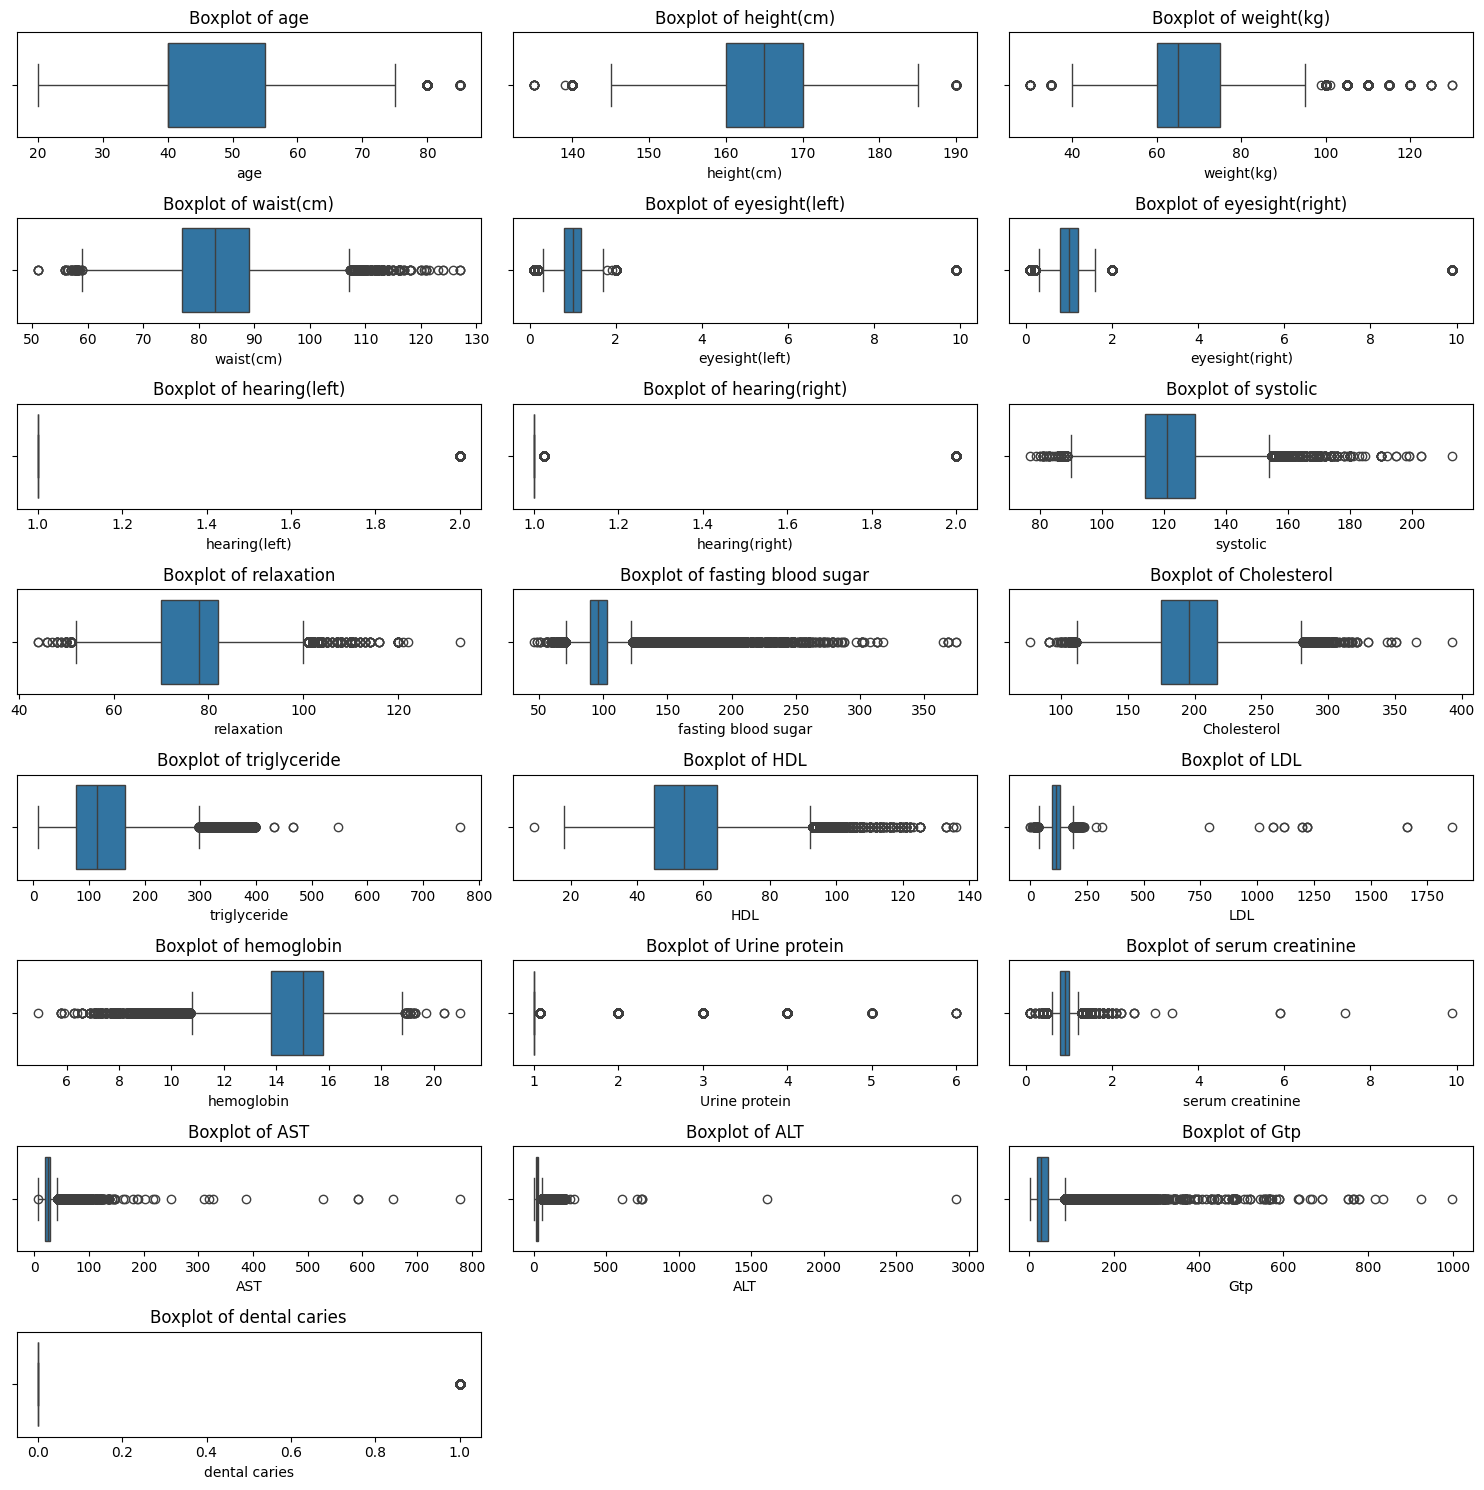

In [9]:
import matplotlib.pyplot as plt

# Boxplot of each feature
num_cols = 3  
num_features = len(X_imputed_df.columns)
num_rows = (num_features - 1) // num_cols + 1 
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5, wspace=0.5)  

for i, column in enumerate(X_imputed_df.columns):
    row = i // num_cols 
    col = i % num_cols  
    sns.boxplot(x=X_imputed_df[column], ax=axs[row, col])
    axs[row, col].set_title(f'Boxplot of {column}')

for i in range(num_features, num_rows * num_cols):
    axs.flat[i].set_visible(False)

plt.tight_layout()
plt.show()

In [10]:
X_scaled_df = pd.DataFrame(X_scaled, columns=train_data.columns[1:-1])
X_scaled_df.describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
count,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,...,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05
mean,2.248666e-17,7.457629e-16,-4.986774e-16,-5.731421e-16,9.757604e-16,4.531017e-16,5.626126e-17,1.139971e-15,4.933680e-16,-6.715659e-16,...,4.367944e-17,1.270675e-16,1.590128e-16,2.104466e-15,-2.534211e-16,-2.696614e-16,-5.650665e-17,7.192162e-17,-3.489001e-17,-7.442013e-17
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,...,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-2.052535e+00,-3.536840e+00,-2.951152e+00,-3.572641e+00,-2.325540e+00,-2.296701e+00,-1.567254e-01,-1.595625e-01,-3.574724e+00,-3.654862e+00,...,-1.807195e+00,-3.355225e+00,-4.034529e+00,-6.915110e+00,-2.195503e-01,-4.420323e+00,-2.062035e+00,-1.439209e+00,-1.096507e+00,-4.968663e-01
25%,-3.636662e-01,-6.148414e-01,-5.675808e-01,-6.700668e-01,-5.291234e-01,-5.123228e-01,-1.567254e-01,-1.595625e-01,-6.680387e-01,-7.642430e-01,...,-7.647224e-01,-7.771848e-01,-6.963241e-01,-6.965898e-01,-2.195503e-01,-5.172393e-01,-5.828779e-01,-5.942820e-01,-5.837613e-01,-4.968663e-01
50%,-3.636662e-01,-3.044168e-02,-1.703190e-01,-2.419952e-04,-1.586156e-02,-2.500338e-03,-1.567254e-01,-1.595625e-01,-1.181252e-01,1.251782e-01,...,-1.906070e-01,-1.326748e-01,-2.158050e-02,1.418624e-01,-2.195503e-01,4.034405e-02,-1.602617e-01,-2.563112e-01,-2.953417e-01,-4.968663e-01
75%,9.029851e-01,5.539581e-01,6.242046e-01,6.695829e-01,4.974003e-01,5.073221e-01,-1.567254e-01,-1.595625e-01,5.889064e-01,5.698888e-01,...,5.648080e-01,5.834474e-01,6.531631e-01,7.008306e-01,-2.195503e-01,5.979274e-01,3.680086e-01,3.069734e-01,2.494507e-01,-4.968663e-01
max,3.436288e+00,2.891557e+00,4.994084e+00,4.911807e+00,2.282429e+01,2.268460e+01,6.380587e+00,6.667150e+00,7.109309e+00,6.239949e+00,...,9.644897e+00,5.739527e+00,6.198381e+01,4.334123e+00,1.464513e+01,5.022284e+01,7.950289e+01,1.626456e+02,3.085397e+01,2.012614e+00


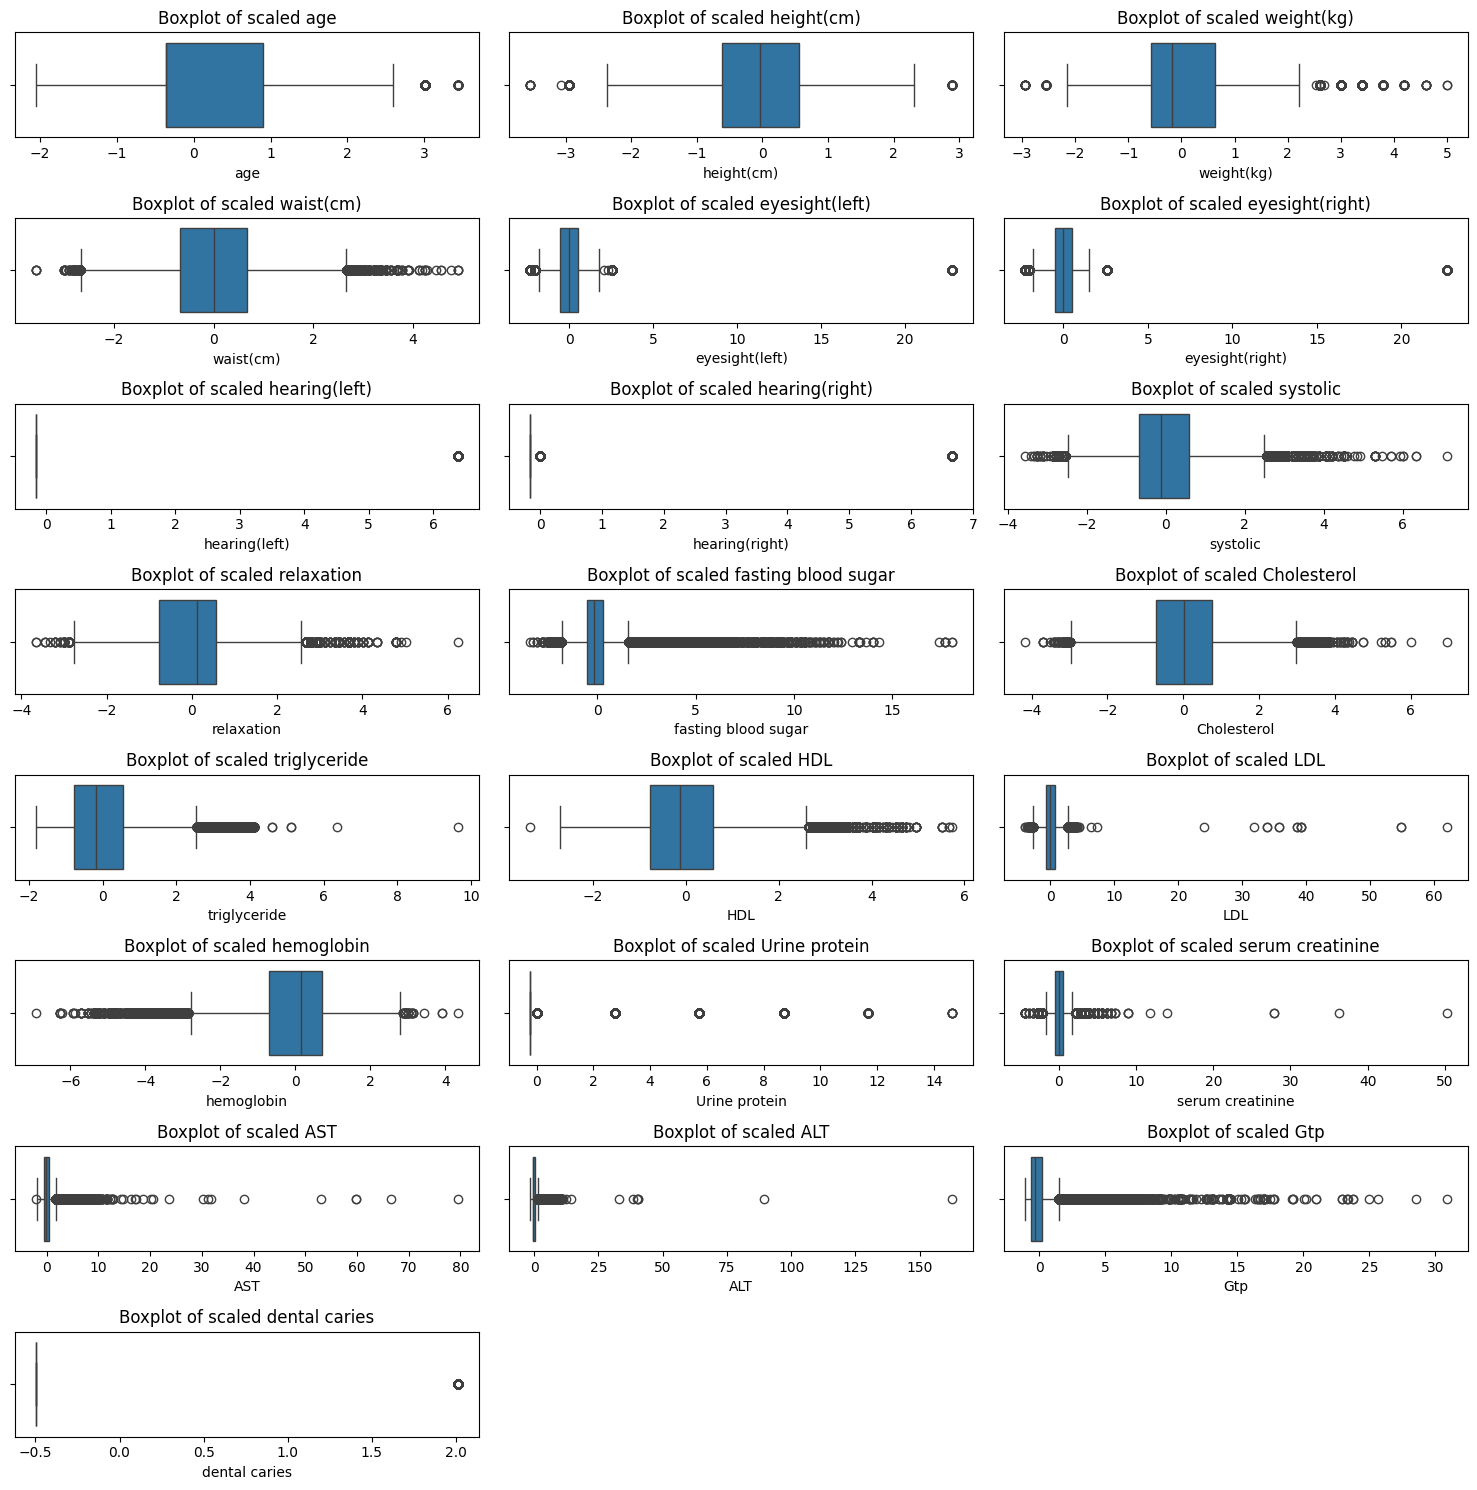

In [11]:
import matplotlib.pyplot as plt

# Boxplot of each feature
num_cols = 3 
num_features = len(X_scaled_df.columns)
num_rows = (num_features - 1) // num_cols + 1 
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5, wspace=0.5) 

for i, column in enumerate(X_scaled_df.columns):
    row = i // num_cols  
    col = i % num_cols   
    sns.boxplot(x=X_scaled_df[column], ax=axs[row, col])
    axs[row, col].set_title(f'Boxplot of scaled {column}')

for i in range(num_features, num_rows * num_cols):
    axs.flat[i].set_visible(False)

plt.tight_layout()
plt.show()

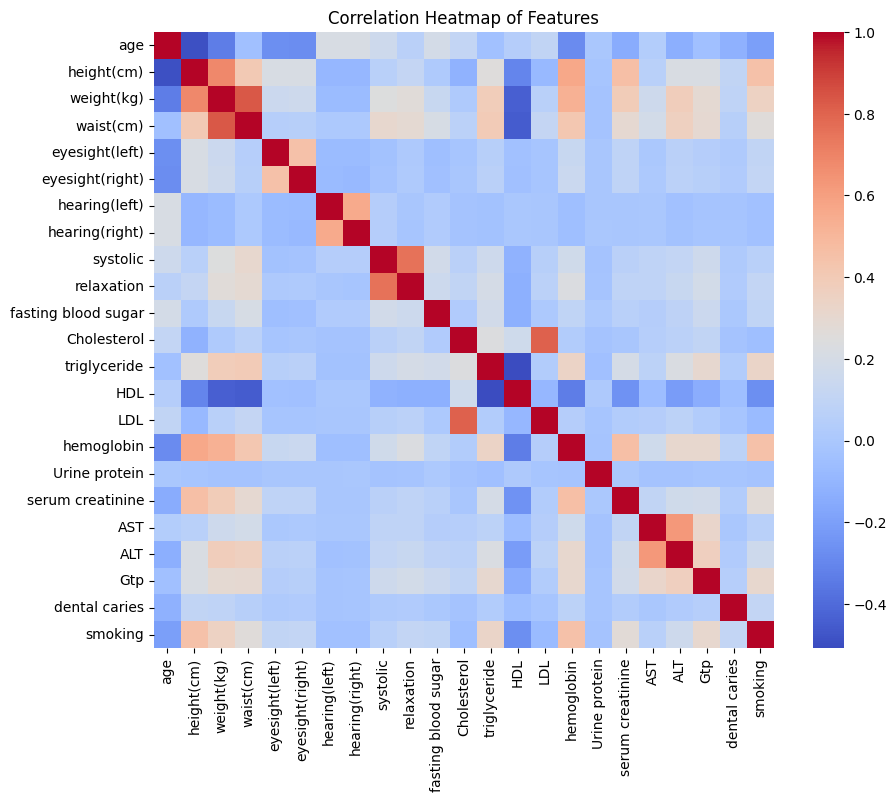

In [12]:
# Calculate the correlation matrix between features
correlation_matrix = train_data.iloc[:, 1:].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

## 3. Feature Engineering

In [5]:
# Concatenate training and test data without labels
all_data = pd.concat([train_data.iloc[:, 1:-1], test_data.iloc[:, 1:-1]], axis=0)

# Impute missing values using mean strategy
imputer = SimpleImputer(strategy='mean')
all_data_imputed = imputer.fit_transform(all_data)

In [7]:
# Create new feature: BMI
height_cm = all_data_imputed[:, all_data.columns.get_loc('height(cm)')]
weight_kg = all_data_imputed[:, all_data.columns.get_loc('weight(kg)')]
BMI = weight_kg / ((height_cm / 100) ** 2)  # BMI calculation formula
all_data_imputed = np.column_stack((all_data_imputed, BMI.reshape(-1, 1)))

# Create new feature: Average Eyesight
left_eyesight = all_data_imputed[:, all_data.columns.get_loc('eyesight(left)')]
right_eyesight = all_data_imputed[:, all_data.columns.get_loc('eyesight(right)')]
average_eyesight = (left_eyesight + right_eyesight) / 2  # Average eyesight calculation formula
all_data_imputed = np.column_stack((all_data_imputed, average_eyesight.reshape(-1, 1)))

# Create new feature: Average Hearing
left_hearing = all_data_imputed[:, all_data.columns.get_loc('hearing(left)')]
right_hearing = all_data_imputed[:, all_data.columns.get_loc('hearing(right)')]
average_hearing = (left_hearing + right_hearing) / 2  # Average hearing calculation formula
all_data_imputed = np.column_stack((all_data_imputed, average_hearing.reshape(-1, 1)))

In [13]:
# Split the processed data back into training and testing sets
X_improved = all_data_imputed[:len(train_data)]
X_test_improved = all_data_imputed[len(train_data):]
y = train_data.iloc[:, -1]    
y_test = test_data.iloc[:, -1]    

# Ensure the correct separation of training and testing sets
print(f"Number of features in training set: {X_improved.shape[1]}")
print(f"Number of features in testing set: {X_test_improved.shape[1]}")

Number of features in training set: 25
Number of features in testing set: 25


## 4. Model Training

###  LGBMClassifier
```python
import lightgbm as lgb
```

In [24]:
# Define the parameters grid for tuning
param_grid = {
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [5, 10, -1],  # -1 means no limit
    'min_child_samples': [20, 30, 50],
}

# Split the dataset into training and validation sets
X_train_improved, X_val_improved, y_train, y_val = train_test_split(X_improved, y, test_size=0.01, random_state=42)

# Initialize LightGBM classifier
lgb_classifier = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', metric='auc', n_jobs=-1, verbosity=1)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=lgb_classifier, param_grid=param_grid, scoring='roc_auc', cv=5)


In [25]:
# Fit GridSearchCV to find best parameters
grid_search.fit(X_train_improved, y_train)

# Get the best model from GridSearchCV
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_

[LightGBM] [Info] Number of positive: 55134, number of negative: 70996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437120 -> initscore=-0.252857
[LightGBM] [Info] Start training from score -0.252857
[LightGBM] [Info] Number of positive: 55133, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2371
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437113 -> initscore=-0.252889
[LightGBM] [Info] Start training from score -0.252889
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 55134, number of negative: 70996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437120 -> initscore=-0.252857
[LightGBM] [Info] Start training from score -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 55133, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437113 -> initscore=-0.252889
[LightGBM] [Info] Start training from score -0.252889
[LightGBM] [Info] Number of positive: 55134, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2357
[LightGBM] [Info] Number of data points in the train set: 126131, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437117 -> initscore=-0.252871
[LightGBM] [Info] Start training from score -0.252871
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 55134, number of negative: 70996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

[LightGBM] [Info] Number of positive: 55133, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437113 -> initscore=-0.252889
[LightGBM] [Info] Start training from score -0.252889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 55134, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2357
[LightGBM] [Info] Number of data points in the train set: 126131, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437117 -> initscore=-0.252871
[LightGBM] [Info] Start training from score -0.252871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 55134, number of negative: 70997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 126131, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437117 -> initscore=-0.252871
[LightGBM] [Info] Start training from score -0.252871
[LightGBM] [Info] Number of positive: 55134, number of negative: 70996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437120 -> initscore=-0.252857


[LightGBM] [Info] Number of positive: 55133, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2371
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437113 -> initscore=-0.252889
[LightGBM] [Info] Start training from score -0.252889
[LightGBM] [Info] Number of positive: 55133, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437113 -> initscore=-0.252889
[LightGBM] [Info] Start training from score -0.252889
[LightGBM]

[LightGBM] [Info] Number of positive: 55134, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2357
[LightGBM] [Info] Number of data points in the train set: 126131, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437117 -> initscore=-0.252871
[LightGBM] [Info] Start training from score -0.252871
[LightGBM] [Info] Number of positive: 55134, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 126131, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437117 -> initscore=-0.252871
[LightGBM] [Info] Start training from score -0.252871
[LightGBM]

[LightGBM] [Info] Number of positive: 55134, number of negative: 70996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437120 -> initscore=-0.252857
[LightGBM] [Info] Start training from score -0.252857
[LightGBM] [Info] Number of positive: 55133, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2371
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437113 -> initscore=-0.252889


[LightGBM] [Info] Number of positive: 55133, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437113 -> initscore=-0.252889
[LightGBM] [Info] Start training from score -0.252889
[LightGBM] [Info] Number of positive: 55134, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2357
[LightGBM] [Info] Number of data points in the train set: 126131, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437117 -> initscore=-0.252871
[LightGBM] [Info] Start training from score -0.252871
[LightGBM]

[LightGBM] [Info] Number of positive: 55134, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 126131, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437117 -> initscore=-0.252871
[LightGBM] [Info] Start training from score -0.252871
[LightGBM] [Info] Number of positive: 55134, number of negative: 70996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437120 -> initscore=-0.252857
[LightGBM] [Info] Start training from score -0.252857
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 55133, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437113 -> initscore=-0.252889
[LightGBM] [Info] Start training from score -0.252889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 55134, number of negative: 70997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 126131, num

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 55134, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2357
[LightGBM] [Info] Number of data points in the train set: 126131, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437117 -> initscore=-0.252871
[LightGBM] [Info] Start training from score -0.252871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 55133, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2371
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437113 -> initscore=-0.252889
[LightGBM] [Info] Start training from score -0.252889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 55134, number of negative: 70996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScor

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 55134, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 126131, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437117 -> initscore=-0.252871
[LightGBM] [Info] Start training from score -0.252871
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Info] Number of positive: 55134, number of negative: 70996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437120 -> initscore=-0.252857
[LightGBM] [Info] Start training from score -0.252857
[LightGBM] [Info] Number of positive: 55133, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2371
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437113 -> initscore=-0.252889
[LightGBM] [Info] Start training from score -0.252889
[LightGBM]

[LightGBM] [Info] Number of positive: 55133, number of negative: 70997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437113 -> initscore=-0.252889
[LightGBM] [Info] Start training from score -0.252889
[LightGBM] [Info] Number of positive: 55134, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2357
[LightGBM] [Info] Number of data points in the train set: 126131, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437117 -> initscore=-0.252871


[LightGBM] [Info] Number of positive: 55134, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 126131, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437117 -> initscore=-0.252871
[LightGBM] [Info] Start training from score -0.252871
[LightGBM] [Info] Number of positive: 55134, number of negative: 70996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437120 -> initscore=-0.252857


[LightGBM] [Info] Number of positive: 55133, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2371
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437113 -> initscore=-0.252889
[LightGBM] [Info] Start training from score -0.252889
[LightGBM] [Info] Number of positive: 55133, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437113 -> initscore=-0.252889
[LightGBM] [Info] Start training from score -0.252889
[LightGBM]

[LightGBM] [Info] Number of positive: 55134, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2357
[LightGBM] [Info] Number of data points in the train set: 126131, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437117 -> initscore=-0.252871
[LightGBM] [Info] Start training from score -0.252871
[LightGBM] [Info] Number of positive: 55134, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 126131, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437117 -> initscore=-0.252871
[LightGBM] [Info] Start training from score -0.252871
[LightGBM]

[LightGBM] [Info] Number of positive: 55134, number of negative: 70996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437120 -> initscore=-0.252857
[LightGBM] [Info] Start training from score -0.252857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 55133, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

[LightGBM] [Info] Number of positive: 55133, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2371
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437113 -> initscore=-0.252889
[LightGBM] [Info] Start training from score -0.252889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 55133, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437113 -> initscore=-0.252889
[LightGBM] [Info] Start training from score -0.252889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 55134, number of negative: 70996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437120 -> initscore=-0.252857
[LightGBM] [Info] Start training from score -0.252857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Info] Number of positive: 55133, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2371
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437113 -> initscore=-0.252889
[LightGBM] [Info] Start training from score -0.252889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 55134, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2357
[LightGBM] [Info] Number of data points in the train set: 126131, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437117 -> initscore=-0.252871
[LightGBM] [Info] Start training from score -0.252871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Info] Number of positive: 55134, number of negative: 70996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437120 -> initscore=-0.252857
[LightGBM] [Info] Start training from score -0.252857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 55134, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2357
[LightGBM] [Info] Number of data points in the train set: 126131, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437117 -> initscore=-0.252871
[LightGBM] [Info] Start training from score -0.252871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 55134, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2357
[LightGBM] [Info] Number of data points in the train set: 126131, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437117 -> initscore=-0.252871
[LightGBM] [Info] Start training from score -0.252871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 55134, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2357
[LightGBM] [Info] Number of data points in the train set: 126131, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437117 -> initscore=-0.252871
[LightGBM] [Info] Start training from score -0.252871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Info] Number of positive: 55134, number of negative: 70996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437120 -> initscore=-0.252857
[LightGBM] [Info] Start training from score -0.252857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 55134, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2357
[LightGBM] [Info] Number of data points in the train set: 126131, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437117 -> initscore=-0.252871
[LightGBM] [Info] Start training from score -0.252871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 55134, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 126131, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437117 -> initscore=-0.252871
[LightGBM] [Info] Start training from score -0.252871
[LightGBM] [Info] Number of positive: 55134, number of negative: 70996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437120 -> initscore=-0.252857
[LightGBM] [Info] Start training from score -0.252857
[LightGBM]

[LightGBM] [Info] Number of positive: 55133, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2371
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437113 -> initscore=-0.252889
[LightGBM] [Info] Start training from score -0.252889
[LightGBM] [Info] Number of positive: 55133, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437113 -> initscore=-0.252889
[LightGBM] [Info] Start training from score -0.252889
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 55134, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2357
[LightGBM] [Info] Number of data points in the train set: 126131, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437117 -> initscore=-0.252871
[LightGBM] [Info] Start training from score -0.252871
[LightGBM] [Info] Number of positive: 55134, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 126131, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437117 -> initscore

[LightGBM] [Info] Number of positive: 55134, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 126131, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437117 -> initscore=-0.252871
[LightGBM] [Info] Start training from score -0.252871
[LightGBM] [Info] Number of positive: 55134, number of negative: 70996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437120 -> initscore=-0.252857
[LightGBM] [Info] Start training from score -0.252857
[LightGBM]

[LightGBM] [Info] Number of positive: 55133, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2371
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437113 -> initscore=-0.252889
[LightGBM] [Info] Start training from score -0.252889
[LightGBM] [Info] Number of positive: 55133, number of negative: 70997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 126130, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437113 -> initscore=-0.252889
[LightGBM] [Info] Start training from score -0.252889
[LightGBM]

Best Parameters: {'learning_rate': 0.2, 'max_depth': 10, 'min_child_samples': 50, 'num_leaves': 30}
Best ROC-AUC Score: 0.865002584046359
Validation ROC-AUC Score: 0.8569691415960631


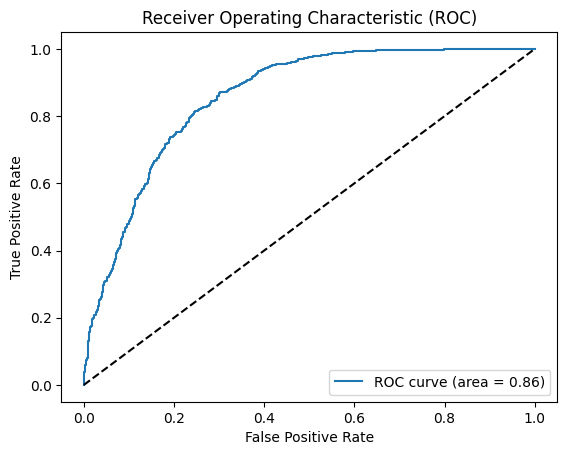

In [26]:
print(f"Best Parameters: {best_params}")
print(f"Best ROC-AUC Score: {best_score}")

# Predict probabilities for the validation set using the best model
y_val_pred_proba = best_model.predict_proba(X_val_improved)[:, 1]

# Calculate ROC-AUC score for validation set
roc_auc = roc_auc_score(y_val, y_val_pred_proba)
print(f"Validation ROC-AUC Score: {roc_auc}")

# Generate ROC curve for the validation set
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## 5. Use Model to Do Classification On Test set

In [27]:
test_predictions = best_model.predict_proba(X_test_improved)[:, 1]

In [28]:
test_data['smoking'] = test_predictions
test_data = test_data[['id', 'smoking']]
test_data.to_csv('Q5_output.csv', index=False)`